In [1]:
import numpy as np
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch import autograd, nn, optim,  distributions
from torch.distributions import MultivariateNormal
from torchvision import datasets, transforms

In [2]:
batch_size = 256
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Load dataset

In [3]:
def get_mnist_data(device, batch_size):
    preprocess = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)) ])
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True, transform=preprocess),
        batch_size=batch_size,
        shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, download=True, transform=preprocess),
        batch_size=batch_size,
        shuffle=True)

    return train_loader, test_loader

train_loader, test_loader = get_mnist_data(device, batch_size)

### test data

In [ ]:
# Create pre-processed training and test sets
X_train = train_loader.dataset.train_data.to(device).reshape(-1, 784).float() / 255
y_train = train_loader.dataset.train_labels.to(device)
X_test = test_loader.dataset.test_data.to(device).reshape(-1, 784).float() / 255
y_test = test_loader.dataset.test_labels.to(device)

In [ ]:
x = torch.arange(8)
for _ in range(4):
    x = torch.flip(x, [0])
    print(x)
x

tensor([7, 6, 5, 4, 3, 2, 1, 0])
tensor([0, 1, 2, 3, 4, 5, 6, 7])
tensor([7, 6, 5, 4, 3, 2, 1, 0])
tensor([0, 1, 2, 3, 4, 5, 6, 7])


tensor([0, 1, 2, 3, 4, 5, 6, 7])

In [ ]:
x.chunk(2)

(tensor([0, 1, 2, 3]), tensor([4, 5, 6, 7]))

In [ ]:
H, W = 4, 4
mask = np.arange(H).reshape(-1, 1) + np.arange(W)
mask

array([[0, 1, 2, 3],
       [1, 2, 3, 4],
       [2, 3, 4, 5],
       [3, 4, 5, 6]])

In [ ]:
mask = np.mod(True + mask, 2)
mask

array([[[[0, 1, 0, 1],
         [1, 0, 1, 0],
         [0, 1, 0, 1],
         [1, 0, 1, 0]]]])

In [ ]:
mask = mask.reshape(-1, 1, H, W)
mask

array([[[[1, 0, 1, 0],
         [0, 1, 0, 1],
         [1, 0, 1, 0],
         [0, 1, 0, 1]]]])

## RealNVP Model

### CouplingLayer

In [4]:
# --- defines the model and the optimizer ---- #
class CouplingLayer(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim):
        super().__init__()
        self.input_dim = input_dim // 2
        self.output_dim = output_dim //2

        self.s = nn.Sequential( nn.Linear(self.input_dim, hid_dim),
                                nn.ReLU(),
                                nn.Linear(hid_dim, hid_dim),
                                nn.ReLU(),
                                nn.Linear(hid_dim, self.output_dim),
                                nn.Tanh())

        self.t = nn.Sequential( nn.Linear(self.input_dim, hid_dim),
                        nn.ReLU(),
                        nn.Linear(hid_dim, hid_dim),
                        nn.ReLU(),
                        nn.Linear(hid_dim, self.output_dim))


    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        s_transformed = self.s(x1)
        t_transformed = self.t(x1)

        y2 = x2 * torch.exp(self.s(x1))+self.t(x1)

        z = torch.cat([x1, y2], dim=1)

        log_det_jac = s_transformed.sum(dim=1)

        return z, log_det_jac


    def backward(self, y):
        y1, y2 = y.chunk(2, dim=1)
        s_transformed = self.s(y1)
        t_transformed = self.t(y2)
        x2 = (y2-t_transformed) * torch.exp(-s_transformed)
        x = torch.cat([y1,x2], dim=1)
        return x

### RealNVP

In [5]:
class RealNVP(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, n_layers = 4):
        super().__init__()

        self.prior = MultivariateNormal(torch.zeros(input_dim, device=device), torch.eye(input_dim, device=device))
        self.modules = []
        for _ in range(n_layers):
            self.modules.append(CouplingLayer(input_dim, output_dim, hid_dim))
        self.module_list = nn.ModuleList(self.modules)

    def forward(self, x):
        bsz, _ = x.shape
        ldj_sum = torch.zeros(bsz).to(device) # sum of log determinant of jacobian

        for module in self.module_list:
            x, ldj= module(x)
            ldj_sum += ldj
            x = torch.flip(x, [1])
        return x, ldj_sum

    def backward(self, z):
        for module in reversed(self.module_list):
            z = module.backward(z)
        return z

    def sample(self, n_samples):
        z = self.prior.sample((n_samples,))
        x = self.backward(z)
        return x

## Train Model

### Utils


In [6]:
import csv


def save_report(train_loss, test_loss):
    file_path = "/content/report.csv"
    rows = zip(train_loss, test_loss)
    headers = ['train_loss', 'test_loss']

    with open(file_path, "w") as f:
        writer = csv.writer(f)
        writer.writerow([g for g in headers])
        for row in rows:
            writer.writerow(row)
    return

In [19]:
import matplotlib.pyplot as plt


def plot_loss(train_loss, test_loss):
    _, axes = plt.subplots(1, 1, figsize=(4, 4))
    plt.suptitle("Train and Test Loss During Training", size=16)
    axes.plot(list(range(1, len(train_loss)+1)), train_loss, 'b',label='train loss')
    axes.plot(list(range(1, len(train_loss)+1)), test_loss, 'r', label='test loss')
    axes.set_ylabel('Loss ', size=12, labelpad=7)
    axes.set_xlabel('Epoch', size=12, labelpad=10)
    axes.legend(loc='upper right', fontsize=10)
    axes.grid()

    plt.show()

def plot_samples(model):

    model.eval()
    x_s = model.sample(16)
    x_s = x_s.reshape(16, 28, 28)

    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8,8), sharex=True, sharey=True)
    fig.suptitle('Generated samples')

    c = 0
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(x_s[i].detach().cpu().numpy(), cmap = 'gist_yarg')

        ax.axis('off')

    plt.show()

### Train

In [8]:
INPUT_DIM = 28*28
HIDDEN_DIM = 256
OUTPUT_DIM = 28*28
N_COUPLE_LAYERS = 4

In [9]:
model = RealNVP(INPUT_DIM, OUTPUT_DIM, HIDDEN_DIM,N_COUPLE_LAYERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)
prior_z = distributions.MultivariateNormal(torch.zeros(OUTPUT_DIM).to(device), torch.eye(OUTPUT_DIM).to(device))

In [10]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        loop_test = tqdm(enumerate(test_loader, 1), total=len(test_loader), desc="test", position=0, leave=True)
        for batch_idx, (x, y) in loop_test:
            x = x.to(device).reshape(x.size(0), -1)
            z, log_det_j_sum = model(x)
            cur_loss = -(prior_z.log_prob(z)+torch.abs(log_det_j_sum)).mean().item()
            test_loss += cur_loss

            optimizer.zero_grad()


            loop_test.set_description(f"test - epoch : {epoch}")
            loop_test.set_postfix(
                    loss="{}".format(cur_loss),
                    refresh=True,
            )

    return test_loss/len(test_loader)

In [11]:
def train(epochs):
    ls_train_loss, ls_test_loss = [], []
    model.train()
    for epoch in tqdm(range(epochs)):
        train_loss = 0
        loop_train = tqdm(enumerate(train_loader, 1), total=len(train_loader), desc="train", position=0, leave=True)
        for index, (x, y) in loop_train:
            x = x.to(device).reshape(x.size(0), -1)
            optimizer.zero_grad()
            z, log_det_j_sum = model(x)
            loss = -(prior_z.log_prob(z)+torch.abs(log_det_j_sum)).mean()
            loss.backward()
            cur_loss = loss.item()
            train_loss += cur_loss
            optimizer.step()


            loop_train.set_description(f"train - epoch : {epoch}")
            loop_train.set_postfix(
                        loss="{}".format(cur_loss),
                        log = "{}".format(prior_z.log_prob(z).mean()),
                        det = "{}".format(torch.abs(log_det_j_sum).mean()),
                        refresh=True,)

        test_loss = test(epoch)
        print("epoch train loss: ", train_loss / len(train_loader))
        scheduler.step()

        ls_train_loss.append(train_loss / len(train_loader))
        ls_test_loss.append(test_loss)

    return ls_train_loss, ls_test_loss

#### 200 1e-4

  0%|          | 1/200 [00:19<1:03:23, 19.11s/it]

epoch train loss:  326.98432147249264


  1%|          | 2/200 [00:39<1:05:11, 19.76s/it]

epoch train loss:  -60.53264870136342


  2%|▏         | 3/200 [00:58<1:04:24, 19.62s/it]

epoch train loss:  -155.21102830602769


  2%|▏         | 4/200 [01:19<1:04:57, 19.88s/it]

epoch train loss:  -207.25049185245595


  2%|▎         | 5/200 [01:39<1:04:49, 19.95s/it]

epoch train loss:  -242.2011768097573


  3%|▎         | 6/200 [01:58<1:03:42, 19.70s/it]

epoch train loss:  -267.7400835402468


  4%|▎         | 7/200 [02:18<1:03:53, 19.86s/it]

epoch train loss:  -285.5450125187001


  4%|▍         | 8/200 [02:37<1:02:39, 19.58s/it]

epoch train loss:  -300.7103037732713


  4%|▍         | 9/200 [02:56<1:01:58, 19.47s/it]

epoch train loss:  -314.1864474682098


  5%|▌         | 10/200 [03:16<1:01:56, 19.56s/it]

epoch train loss:  -325.60853232525767


  6%|▌         | 11/200 [03:35<1:01:06, 19.40s/it]

epoch train loss:  -336.6045345225233


  6%|▌         | 12/200 [03:55<1:01:18, 19.57s/it]

epoch train loss:  -344.4618018617021


  6%|▋         | 13/200 [04:14<1:00:40, 19.47s/it]

epoch train loss:  -351.7415535135472


  7%|▋         | 14/200 [04:34<1:00:37, 19.56s/it]

epoch train loss:  -358.77921064660904


  8%|▊         | 15/200 [04:53<1:00:07, 19.50s/it]

epoch train loss:  -365.23953701587436


  8%|▊         | 16/200 [05:12<59:13, 19.31s/it]  

epoch train loss:  -371.91721749813


  8%|▊         | 17/200 [05:32<59:40, 19.57s/it]

epoch train loss:  -376.51203587308845


  9%|▉         | 18/200 [05:52<59:11, 19.51s/it]

epoch train loss:  -381.1989385077294


 10%|▉         | 19/200 [06:11<58:55, 19.53s/it]

epoch train loss:  -385.4222258872174


 10%|█         | 20/200 [06:31<58:46, 19.59s/it]

epoch train loss:  -389.408259614985


 10%|█         | 21/200 [06:50<58:07, 19.48s/it]

epoch train loss:  -393.8380112668301


 11%|█         | 22/200 [07:10<58:19, 19.66s/it]

epoch train loss:  -396.93010994119845


 12%|█▏        | 23/200 [07:30<57:37, 19.53s/it]

epoch train loss:  -399.7832885742188


 12%|█▏        | 24/200 [07:50<57:50, 19.72s/it]

epoch train loss:  -402.6740744732796


 12%|█▎        | 25/200 [08:09<57:03, 19.56s/it]

epoch train loss:  -405.55745927526596


 13%|█▎        | 26/200 [08:29<56:56, 19.64s/it]

epoch train loss:  -408.6388995231466


 14%|█▎        | 27/200 [08:48<56:37, 19.64s/it]

epoch train loss:  -410.83163530065656


 14%|█▍        | 28/200 [09:08<56:03, 19.55s/it]

epoch train loss:  -413.0055874438996


 14%|█▍        | 29/200 [09:28<56:33, 19.84s/it]

epoch train loss:  -414.8736502140126


 15%|█▌        | 30/200 [09:48<56:09, 19.82s/it]

epoch train loss:  -416.93980115525267


 16%|█▌        | 31/200 [10:09<56:28, 20.05s/it]

epoch train loss:  -419.3302005848986


 16%|█▌        | 32/200 [10:28<55:45, 19.91s/it]

epoch train loss:  -420.8156107151762


 16%|█▋        | 33/200 [10:49<55:48, 20.05s/it]

epoch train loss:  -422.4021798641124


 17%|█▋        | 34/200 [11:09<55:36, 20.10s/it]

epoch train loss:  -424.0548617748504


 18%|█▊        | 35/200 [11:28<54:47, 19.92s/it]

epoch train loss:  -425.4840887840758


 18%|█▊        | 36/200 [11:49<54:45, 20.03s/it]

epoch train loss:  -427.26633729325965


 18%|█▊        | 37/200 [12:08<53:55, 19.85s/it]

epoch train loss:  -428.3410179625166


 19%|█▉        | 38/200 [12:29<54:04, 20.03s/it]

epoch train loss:  -429.5201591329372


 20%|█▉        | 39/200 [12:48<52:54, 19.72s/it]

epoch train loss:  -430.7792660976978


 20%|██        | 40/200 [13:07<52:33, 19.71s/it]

epoch train loss:  -431.9118636760306


 20%|██        | 41/200 [13:27<52:09, 19.68s/it]

epoch train loss:  -433.19705317071146


 21%|██        | 42/200 [13:46<51:29, 19.55s/it]

epoch train loss:  -434.15161911984706


 22%|██▏       | 43/200 [14:06<51:33, 19.71s/it]

epoch train loss:  -435.0948870719747


 22%|██▏       | 44/200 [14:25<50:50, 19.55s/it]

epoch train loss:  -435.9983338700964


 22%|██▎       | 45/200 [14:45<50:51, 19.69s/it]

epoch train loss:  -436.85505799638463


 23%|██▎       | 46/200 [15:05<50:26, 19.66s/it]

epoch train loss:  -437.9395342887716


 24%|██▎       | 47/200 [15:24<49:48, 19.53s/it]

epoch train loss:  -438.64888565388134


 24%|██▍       | 48/200 [15:45<50:07, 19.79s/it]

epoch train loss:  -439.41920153029423


 24%|██▍       | 49/200 [16:04<49:23, 19.62s/it]

epoch train loss:  -440.08880238634475


 25%|██▌       | 50/200 [16:25<49:57, 19.98s/it]

epoch train loss:  -440.6995387300532


 26%|██▌       | 51/200 [16:44<49:19, 19.86s/it]

epoch train loss:  -441.5547807409408


 26%|██▌       | 52/200 [17:05<49:20, 20.00s/it]

epoch train loss:  -442.1707953270446


 26%|██▋       | 53/200 [17:24<48:54, 19.96s/it]

epoch train loss:  -442.77397785592586


 27%|██▋       | 54/200 [17:44<48:37, 19.98s/it]

epoch train loss:  -443.2988699405751


 28%|██▊       | 55/200 [18:05<48:31, 20.08s/it]

epoch train loss:  -443.82420991938164


 28%|██▊       | 56/200 [18:24<47:32, 19.81s/it]

epoch train loss:  -444.4228787036652


 28%|██▊       | 57/200 [18:45<47:55, 20.11s/it]

epoch train loss:  -445.00668841422873


 29%|██▉       | 58/200 [19:04<47:09, 19.92s/it]

epoch train loss:  -445.41727113115024


 30%|██▉       | 59/200 [19:24<46:48, 19.92s/it]

epoch train loss:  -445.886658623878


 30%|███       | 60/200 [19:44<46:20, 19.86s/it]

epoch train loss:  -446.33740403195645


 30%|███       | 61/200 [20:03<45:34, 19.67s/it]

epoch train loss:  -446.81389952314663


 31%|███       | 62/200 [20:24<45:48, 19.92s/it]

epoch train loss:  -447.2423996945645


 32%|███▏      | 63/200 [20:43<45:04, 19.74s/it]

epoch train loss:  -447.54048539831285


 32%|███▏      | 64/200 [21:03<45:06, 19.90s/it]

epoch train loss:  -447.9570616377161


 32%|███▎      | 65/200 [21:22<44:20, 19.71s/it]

epoch train loss:  -448.249966235871


 33%|███▎      | 66/200 [21:42<44:12, 19.80s/it]

epoch train loss:  -448.7376986889129


 34%|███▎      | 67/200 [22:02<43:57, 19.83s/it]

epoch train loss:  -449.01521957072805


 34%|███▍      | 68/200 [22:22<43:24, 19.73s/it]

epoch train loss:  -449.3277180123836


 34%|███▍      | 69/200 [22:42<43:37, 19.98s/it]

epoch train loss:  -449.5472944543717


 35%|███▌      | 70/200 [23:01<42:42, 19.71s/it]

epoch train loss:  -449.8588785374418


 36%|███▌      | 71/200 [23:22<42:46, 19.90s/it]

epoch train loss:  -450.18787023666056


 36%|███▌      | 72/200 [23:41<42:15, 19.81s/it]

epoch train loss:  -450.47781761656415


 36%|███▋      | 73/200 [24:01<41:52, 19.78s/it]

epoch train loss:  -450.63122000187


 37%|███▋      | 74/200 [24:21<41:36, 19.82s/it]

epoch train loss:  -450.9005269801363


 38%|███▊      | 75/200 [24:41<41:09, 19.76s/it]

epoch train loss:  -451.14321237117684


 38%|███▊      | 76/200 [25:01<41:06, 19.89s/it]

epoch train loss:  -451.4091957903923


 38%|███▊      | 77/200 [25:20<40:21, 19.69s/it]

epoch train loss:  -451.59150442569813


 39%|███▉      | 78/200 [25:41<40:30, 19.92s/it]

epoch train loss:  -451.74898993309506


 40%|███▉      | 79/200 [26:00<39:54, 19.79s/it]

epoch train loss:  -451.944752924493


 40%|████      | 80/200 [26:19<39:21, 19.68s/it]

epoch train loss:  -452.1338845110954


 40%|████      | 81/200 [26:39<39:14, 19.79s/it]

epoch train loss:  -452.37994813310337


 41%|████      | 82/200 [26:59<38:38, 19.65s/it]

epoch train loss:  -452.51975279463096


 42%|████▏     | 83/200 [27:19<38:55, 19.96s/it]

epoch train loss:  -452.7336376433677


 42%|████▏     | 84/200 [27:39<38:15, 19.78s/it]

epoch train loss:  -452.8066121852144


 42%|████▎     | 85/200 [27:59<38:21, 20.01s/it]

epoch train loss:  -452.91905816260805


 43%|████▎     | 86/200 [28:19<37:51, 19.92s/it]

epoch train loss:  -453.11183380776265


 44%|████▎     | 87/200 [28:39<37:19, 19.82s/it]

epoch train loss:  -453.25215051529256


 44%|████▍     | 88/200 [28:59<37:22, 20.03s/it]

epoch train loss:  -453.36191263401764


 44%|████▍     | 89/200 [29:19<36:41, 19.84s/it]

epoch train loss:  -453.5843381191822


 45%|████▌     | 90/200 [29:39<36:47, 20.07s/it]

epoch train loss:  -453.6391583381815


 46%|████▌     | 91/200 [29:59<36:19, 19.99s/it]

epoch train loss:  -453.8185237803358


 46%|████▌     | 92/200 [30:20<36:32, 20.30s/it]

epoch train loss:  -453.8213686679272


 46%|████▋     | 93/200 [30:40<36:12, 20.30s/it]

epoch train loss:  -453.91892141788566


 47%|████▋     | 94/200 [31:01<36:06, 20.44s/it]

epoch train loss:  -454.0528385243517


 48%|████▊     | 95/200 [31:21<35:35, 20.33s/it]

epoch train loss:  -454.1453796386719


 48%|████▊     | 96/200 [31:41<34:51, 20.11s/it]

epoch train loss:  -454.22689053149935


 48%|████▊     | 97/200 [32:01<34:35, 20.15s/it]

epoch train loss:  -454.3342412421044


 49%|████▉     | 98/200 [32:20<33:54, 19.94s/it]

epoch train loss:  -454.49060980614195


 50%|████▉     | 99/200 [32:41<33:59, 20.19s/it]

epoch train loss:  -454.50171820457945


 50%|█████     | 100/200 [33:01<33:22, 20.02s/it]

epoch train loss:  -454.54272214199636


 50%|█████     | 101/200 [33:21<33:08, 20.09s/it]

epoch train loss:  -454.6820395611702


 51%|█████     | 102/200 [33:41<32:45, 20.05s/it]

epoch train loss:  -454.8071946164395


 52%|█████▏    | 103/200 [34:01<32:27, 20.08s/it]

epoch train loss:  -454.8108964635971


 52%|█████▏    | 104/200 [34:22<32:17, 20.18s/it]

epoch train loss:  -454.8466583901263


 52%|█████▎    | 105/200 [34:41<31:47, 20.08s/it]

epoch train loss:  -454.92038963804856


 53%|█████▎    | 106/200 [35:02<31:46, 20.29s/it]

epoch train loss:  -455.0445372236536


 54%|█████▎    | 107/200 [35:22<31:12, 20.14s/it]

epoch train loss:  -455.03313455784576


 54%|█████▍    | 108/200 [35:43<31:06, 20.29s/it]

epoch train loss:  -455.1052051300698


 55%|█████▍    | 109/200 [36:02<30:25, 20.06s/it]

epoch train loss:  -455.12769996156084


 55%|█████▌    | 110/200 [36:23<30:11, 20.13s/it]

epoch train loss:  -455.33324221347243


 56%|█████▌    | 111/200 [36:43<29:56, 20.19s/it]

epoch train loss:  -455.26413898873835


 56%|█████▌    | 112/200 [37:03<29:33, 20.15s/it]

epoch train loss:  -455.30747771567485


 56%|█████▋    | 113/200 [37:24<29:25, 20.30s/it]

epoch train loss:  -455.35735291825966


 57%|█████▋    | 114/200 [37:44<28:57, 20.20s/it]

epoch train loss:  -455.37893391061334


 57%|█████▊    | 115/200 [38:05<29:05, 20.54s/it]

epoch train loss:  -455.5172224328873


 58%|█████▊    | 116/200 [38:25<28:34, 20.42s/it]

epoch train loss:  -455.47069624231216


 58%|█████▊    | 117/200 [38:46<28:27, 20.58s/it]

epoch train loss:  -455.55894827335436


 59%|█████▉    | 118/200 [39:06<27:53, 20.40s/it]

epoch train loss:  -455.57049664436505


 60%|█████▉    | 119/200 [39:27<27:46, 20.58s/it]

epoch train loss:  -455.59788818359374


 60%|██████    | 120/200 [39:47<27:03, 20.29s/it]

epoch train loss:  -455.640057762633


 60%|██████    | 121/200 [40:07<26:38, 20.24s/it]

epoch train loss:  -455.6741843365608


 61%|██████    | 122/200 [40:27<26:17, 20.23s/it]

epoch train loss:  -455.7212972438082


 62%|██████▏   | 123/200 [40:47<25:50, 20.13s/it]

epoch train loss:  -455.64040358523107


 62%|██████▏   | 124/200 [41:07<25:40, 20.27s/it]

epoch train loss:  -455.72554671916555


 62%|██████▎   | 125/200 [41:27<25:05, 20.07s/it]

epoch train loss:  -455.83202008186504


 63%|██████▎   | 126/200 [41:48<25:00, 20.27s/it]

epoch train loss:  -455.8244625010389


 64%|██████▎   | 127/200 [42:08<24:32, 20.17s/it]

epoch train loss:  -455.79789831283244


 64%|██████▍   | 128/200 [42:28<24:14, 20.20s/it]

epoch train loss:  -455.90341848819816


 64%|██████▍   | 129/200 [42:48<23:48, 20.13s/it]

epoch train loss:  -455.8878415371509


 65%|██████▌   | 130/200 [43:08<23:26, 20.09s/it]

epoch train loss:  -455.78671108813995


 66%|██████▌   | 131/200 [43:28<23:09, 20.13s/it]

epoch train loss:  -455.97376566136137


 66%|██████▌   | 132/200 [43:48<22:40, 20.01s/it]

epoch train loss:  -455.9200462828291


 66%|██████▋   | 133/200 [44:09<22:35, 20.24s/it]

epoch train loss:  -455.9483281561669


 67%|██████▋   | 134/200 [44:28<22:04, 20.07s/it]

epoch train loss:  -455.9978368880901


 68%|██████▊   | 135/200 [44:49<21:58, 20.29s/it]

epoch train loss:  -455.9808050926695


 68%|██████▊   | 136/200 [45:09<21:25, 20.09s/it]

epoch train loss:  -455.9735776211353


 68%|██████▊   | 137/200 [45:29<21:03, 20.06s/it]

epoch train loss:  -456.0640873036486


 69%|██████▉   | 138/200 [45:49<20:47, 20.13s/it]

epoch train loss:  -455.9784941977643


 70%|██████▉   | 139/200 [46:09<20:20, 20.01s/it]

epoch train loss:  -455.99255306162735


 70%|███████   | 140/200 [46:29<20:12, 20.21s/it]

epoch train loss:  -456.0952092596825


 70%|███████   | 141/200 [46:49<19:50, 20.18s/it]

epoch train loss:  -456.0751364849983


 71%|███████   | 142/200 [47:10<19:38, 20.31s/it]

epoch train loss:  -456.12683131441156


 72%|███████▏  | 143/200 [47:30<19:06, 20.11s/it]

epoch train loss:  -456.0766560006649


 72%|███████▏  | 144/200 [47:50<18:50, 20.19s/it]

epoch train loss:  -456.0958341557929


 72%|███████▎  | 145/200 [48:10<18:26, 20.12s/it]

epoch train loss:  -456.13554921251665


 73%|███████▎  | 146/200 [48:30<18:01, 20.03s/it]

epoch train loss:  -456.2223039343002


 74%|███████▎  | 147/200 [48:51<17:52, 20.24s/it]

epoch train loss:  -456.1531126631067


 74%|███████▍  | 148/200 [49:11<17:28, 20.16s/it]

epoch train loss:  -456.1722512103142


 74%|███████▍  | 149/200 [49:31<17:11, 20.22s/it]

epoch train loss:  -456.13960960875164


 75%|███████▌  | 150/200 [49:51<16:44, 20.09s/it]

epoch train loss:  -456.21169537483377


 76%|███████▌  | 151/200 [50:11<16:29, 20.20s/it]

epoch train loss:  -456.20876283036904


 76%|███████▌  | 152/200 [50:31<16:04, 20.10s/it]

epoch train loss:  -456.184840685256


 76%|███████▋  | 153/200 [50:51<15:43, 20.08s/it]

epoch train loss:  -456.17306609458115


 77%|███████▋  | 154/200 [51:11<15:24, 20.09s/it]

epoch train loss:  -456.2134225398936


 78%|███████▊  | 155/200 [51:31<15:01, 20.03s/it]

epoch train loss:  -456.1978461082945


 78%|███████▊  | 156/200 [51:52<14:50, 20.23s/it]

epoch train loss:  -456.21939333651926


 78%|███████▊  | 157/200 [52:12<14:24, 20.11s/it]

epoch train loss:  -456.2668446642287


 79%|███████▉  | 158/200 [52:32<14:09, 20.24s/it]

epoch train loss:  -456.2275410104305


 80%|███████▉  | 159/200 [52:52<13:49, 20.23s/it]

epoch train loss:  -456.26990369431513


 80%|████████  | 160/200 [53:13<13:32, 20.31s/it]

epoch train loss:  -456.2809622257314


 80%|████████  | 161/200 [53:33<13:11, 20.30s/it]

epoch train loss:  -456.2410253646526


 81%|████████  | 162/200 [53:53<12:49, 20.26s/it]

epoch train loss:  -456.2326056297789


 82%|████████▏ | 163/200 [54:14<12:35, 20.42s/it]

epoch train loss:  -456.2133043654421


 82%|████████▏ | 164/200 [54:34<12:09, 20.27s/it]

epoch train loss:  -456.3074861567071


 82%|████████▎ | 165/200 [54:55<11:58, 20.52s/it]

epoch train loss:  -456.30869088680186


 83%|████████▎ | 166/200 [55:15<11:31, 20.35s/it]

epoch train loss:  -456.3194042449302


 84%|████████▎ | 167/200 [55:36<11:15, 20.48s/it]

epoch train loss:  -456.32199044734875


 84%|████████▍ | 168/200 [55:56<10:50, 20.32s/it]

epoch train loss:  -456.28076938061


 84%|████████▍ | 169/200 [56:16<10:32, 20.41s/it]

epoch train loss:  -456.26175796833445


 85%|████████▌ | 170/200 [56:37<10:15, 20.51s/it]

epoch train loss:  -456.2531039623504


 86%|████████▌ | 171/200 [56:57<09:51, 20.40s/it]

epoch train loss:  -456.26381654130654


 86%|████████▌ | 172/200 [57:18<09:35, 20.57s/it]

epoch train loss:  -456.2590312551945


 86%|████████▋ | 173/200 [57:38<09:10, 20.37s/it]

epoch train loss:  -456.25159873150767


 87%|████████▋ | 174/200 [57:59<08:53, 20.51s/it]

epoch train loss:  -456.29646723321144


 88%|████████▊ | 175/200 [58:19<08:29, 20.36s/it]

epoch train loss:  -456.32737102102726


 88%|████████▊ | 176/200 [58:40<08:13, 20.57s/it]

epoch train loss:  -456.3155295514046


 88%|████████▊ | 177/200 [59:00<07:49, 20.39s/it]

epoch train loss:  -456.34439892058674


 89%|████████▉ | 178/200 [59:21<07:31, 20.51s/it]

epoch train loss:  -456.32222744556185


 90%|████████▉ | 179/200 [59:41<07:10, 20.50s/it]

epoch train loss:  -456.3483904899435


 90%|█████████ | 180/200 [1:00:02<06:49, 20.50s/it]

epoch train loss:  -456.3272533660239


 90%|█████████ | 181/200 [1:00:23<06:31, 20.58s/it]

epoch train loss:  -456.3316950371925


 91%|█████████ | 182/200 [1:00:43<06:09, 20.54s/it]

epoch train loss:  -456.30547667158413


 92%|█████████▏| 183/200 [1:01:04<05:51, 20.69s/it]

epoch train loss:  -456.28081275452956


 92%|█████████▏| 184/200 [1:01:24<05:28, 20.55s/it]

epoch train loss:  -456.3974471721243


 92%|█████████▎| 185/200 [1:01:45<05:08, 20.59s/it]

epoch train loss:  -456.3419166077959


 93%|█████████▎| 186/200 [1:02:05<04:46, 20.43s/it]

epoch train loss:  -456.33714859333446


 94%|█████████▎| 187/200 [1:02:26<04:26, 20.47s/it]

epoch train loss:  -456.30002298558014


 94%|█████████▍| 188/200 [1:02:46<04:03, 20.30s/it]

epoch train loss:  -456.3232256950216


 94%|█████████▍| 189/200 [1:03:06<03:43, 20.35s/it]

epoch train loss:  -456.3432345775848


 95%|█████████▌| 190/200 [1:03:27<03:25, 20.51s/it]

epoch train loss:  -456.39450216090427


 96%|█████████▌| 191/200 [1:03:47<03:03, 20.37s/it]

epoch train loss:  -456.37296636053856


 96%|█████████▌| 192/200 [1:04:08<02:44, 20.54s/it]

epoch train loss:  -456.40941356902425


 96%|█████████▋| 193/200 [1:04:28<02:23, 20.43s/it]

epoch train loss:  -456.31269401387965


 97%|█████████▋| 194/200 [1:04:49<02:03, 20.55s/it]

epoch train loss:  -456.2814969975898


 98%|█████████▊| 195/200 [1:05:09<01:41, 20.37s/it]

epoch train loss:  -456.3740425272191


 98%|█████████▊| 196/200 [1:05:29<01:21, 20.45s/it]

epoch train loss:  -456.36814289498835


 98%|█████████▊| 197/200 [1:05:50<01:01, 20.42s/it]

epoch train loss:  -456.37808578166556


 99%|█████████▉| 198/200 [1:06:10<00:40, 20.28s/it]

epoch train loss:  -456.3518409242021


100%|█████████▉| 199/200 [1:06:30<00:20, 20.42s/it]

epoch train loss:  -456.3298529442321


100%|██████████| 200/200 [1:06:50<00:00, 20.05s/it]


epoch train loss:  -456.3560981912816


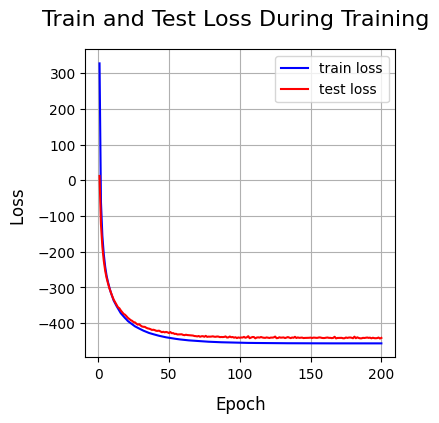

In [12]:
ls_train_loss, ls_test_loss = train(200)
save_report(ls_train_loss, ls_test_loss)
plot_loss(ls_train_loss, ls_test_loss)

## Generate samples

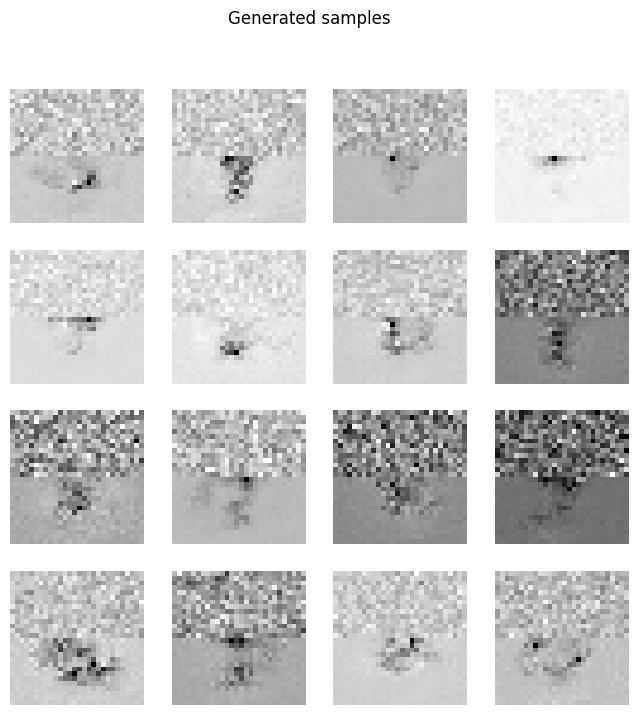

In [24]:
plot_samples(model)

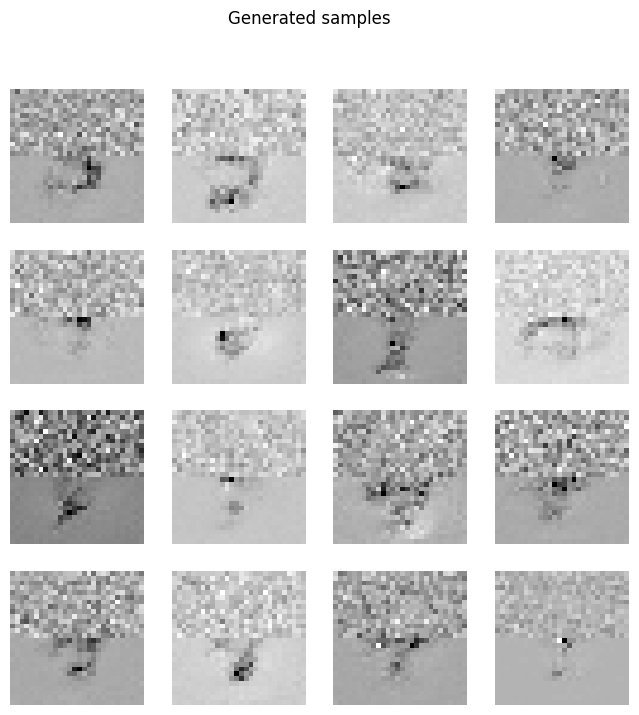

In [15]:
plot_samples(model)